# Project - Spam text message classification
___
The objective of this project is to explore and compare different methods of detecting spam messages. The dataset has  over 5000 rows with 2 columns - category and message. The category tells us whether it is spam or not, and the message is the body of text described.

In [3]:
#download dataset and unzip from here: https://www.kaggle.com/datasets/team-ai/spam-text-message-classification

! pip install numpy lda
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk, lda
import pandas as pd
import numpy as np
from nltk.tokenize import PunktSentenceTokenizer, RegexpTokenizer
from nltk.corpus import stopwords
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from google.colab import files
uploaded = files.upload() 
spamdf = pd.read_csv("SPAM text message 20170820 - Data.csv")
spamdf.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Saving SPAM text message 20170820 - Data.csv to SPAM text message 20170820 - Data.csv


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
len(spamdf)

5572

## EDA

In [5]:
spamdf['message_count']=spamdf['Message'].map(lambda x:len(x.split()))


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Fig.1 message word count by category')

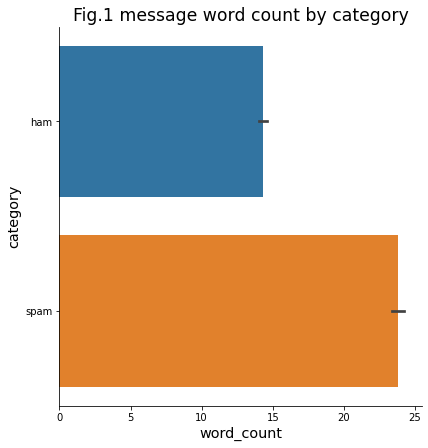

In [9]:
sns.factorplot(data=spamdf, x='message_count',y ='Category', kind='bar', size=6)
plt.xlabel('word_count', fontsize='x-large')
plt.ylabel('category', fontsize='x-large')
plt.title('Fig.1 message word count by category', fontsize='xx-large')

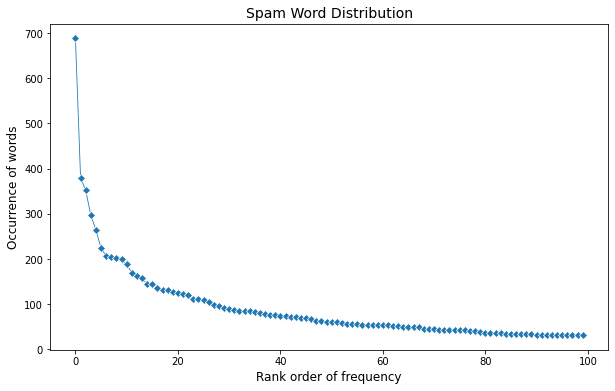

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
x = [i for i in range(100)]
plt.figure(figsize=(10,6))
sns.lineplot(x=x,y=sorted(cspam.values(),reverse=True)[:100],marker='D', linewidth=.8)
plt.title('Spam Word Distribution', fontsize=14)
plt.ylabel('Occurrence of words', fontsize=12)
plt.xlabel('Rank order of frequency', fontsize=12)
plt.show()

## Preprocessing

In [10]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize
#from nltk.util import ngrams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
!pip install scikit-plot
from scikitplot.metrics import plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Removing punctuation
tokenizer = RegexpTokenizer(r'\w+') #removes punctuation, keeps only words
# Stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Words Counter
Punctuation and Stopwords removed

In [11]:
# Function tokenize and count
def counts(x): #count frequencies
  return Counter([t for t in tokenizer.tokenize((x.lower())) if not t in stop_words])

# Applying counts
c_w_counts = spamdf['Message'].astype(str).apply(counts)
# counter of all words
c_w_all = c_w_counts.sum()
# dict of all words
s_w_all = c_w_all.keys()

#### Word Frequency

In [12]:
# Dataframe of word frequency
row = np.zeros(len(s_w_all))
def wordfreq(x):
  r = row.copy() #init new row
  for i,w in enumerate(s_w_all):
    if w in x:
      r[i] = x[w]
  return r
df_word_freq = pd.DataFrame(c_w_counts.apply(wordfreq).tolist(),columns = s_w_all)
df_word_freq

,go,jurong,point,crazy,available,bugis,n,great,world,la,...,nmde,dump,heap,lowes,salesman,087187272008,now1,pity,suggestions,bitching
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
5570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Method 1: Using Lift to find Prominent Words in Spam Messages

In [13]:
df = spamdf.copy()
df["Concat"] = df['Category'].astype(str) +" "+ df["Message"]
concat_words = df['Concat'].astype(str).apply(counts)
all = concat_words.sum()
keys = all.keys()


In [14]:
concat_words

0       {'ham': 1, 'go': 1, 'jurong': 1, 'point': 1, '...
1       {'ham': 1, 'ok': 1, 'lar': 1, 'joking': 1, 'wi...
2       {'spam': 1, 'free': 1, 'entry': 2, '2': 1, 'wk...
3       {'ham': 1, 'u': 2, 'dun': 1, 'say': 2, 'early'...
4       {'ham': 1, 'nah': 1, 'think': 1, 'goes': 1, 'u...
                              ...                        
5567    {'spam': 1, '2nd': 1, 'time': 1, 'tried': 1, '...
5568    {'ham': 1, 'ü': 1, 'b': 1, 'going': 1, 'esplan...
5569    {'ham': 1, 'pity': 1, 'mood': 1, 'suggestions'...
5570    {'ham': 1, 'guy': 1, 'bitching': 1, 'acted': 1...
5571          {'ham': 1, 'rofl': 1, 'true': 1, 'name': 1}
Name: Concat, Length: 5572, dtype: object

In [15]:
def wordfreq(x):
  r = row.copy() #init new row
  for i,w in enumerate(all):
    if w in x:
      r[i] = x[w]
  return r
concat_freq = pd.DataFrame(concat_words.apply(wordfreq).tolist(),columns = keys)
concat_freq

,ham,go,jurong,point,crazy,available,bugis,n,great,world,...,nmde,dump,heap,lowes,salesman,087187272008,now1,pity,suggestions,bitching
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5568,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5569,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
5570,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [16]:
spam_lifts = pd.DataFrame()
N = len(concat_freq)
for w1 in concat_freq.columns:
    nw1 = concat_freq[w1].sum()
    spamcount = concat_freq['spam'].sum()
    mask1 = (concat_freq[w1] == 1)
    mask2 = (concat_freq['spam'] == 1)
    n12 = len(concat_freq[mask1 & mask2])
    lift = (N*n12)/(nw1*spamcount)
    spam_lifts.loc[w1,'Lift'] = lift

In [17]:
spam_lifts

,Lift
ham,0.000000
go,0.815990
jurong,0.000000
point,0.000000
crazy,1.489840
...,...
087187272008,7.449198
now1,7.449198
pity,0.000000
suggestions,0.000000


In [18]:
freq = concat_freq.T
freq['Sum']=freq.sum(axis=1)
freq['Count']=freq.count(axis=1)
freq['Frequency'] = freq['Sum']/freq['Count']

freq

,0,1,2,3,4,5,6,7,8,9,...,5565,5566,5567,5568,5569,5570,5571,Sum,Count,Frequency
ham,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,4829.0,5573,0.866499
go,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,283.0,5573,0.050781
jurong,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5573,0.000179
point,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,5573,0.002333
crazy,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,5573,0.002692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
087187272008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5573,0.000179
now1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5573,0.000179
pity,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,5573,0.000179
suggestions,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,5573,0.000179


In [19]:
spam_lifts_weighted = spam_lifts.merge(freq,left_index=True,right_index=True)
spam_lifts_weighted['Weighted Lift'] = spam_lifts_weighted['Lift']*spam_lifts_weighted['Frequency']
spam_lifts_weighted[['Lift','Frequency','Weighted Lift']].sort_values(by='Weighted Lift', ascending=False)[:25]


,Lift,Frequency,Weighted Lift
spam,7.429280,0.134219,0.997147
call,3.762476,0.105868,0.398324
txt,5.976193,0.031760,0.189806
free,3.357385,0.050960,0.171092
4,2.710870,0.058676,0.159062
2,1.523382,0.095640,0.145696
mobile,5.403291,0.025480,0.137676
1,4.348954,0.031043,0.135003
claim,6.778099,0.019917,0.135003
www,7.300214,0.017944,0.130993


## Method 2: Building a Classification Model
#### Train/Test Split - 75%/25%

In [20]:
# Train size
train_size = 0.75
n_train_size = int(train_size*len(spamdf))

In [21]:
# Indices
np.random.seed(2022)
idx = np.random.permutation(len(spamdf))

train_idx = idx[:n_train_size]
test_idx = idx[n_train_size:]

#### Feature Vectorizing

In [22]:
import string
# Lowercase
def convert_lowercase(x):
    return x.lower()

# Remove URL
def remove_url(x):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', x)

# Remove Punctuation
exclude = string.punctuation
def remove_punc(x):
    return x.translate(str.maketrans('', '', exclude))

# Remove Stopwords
def remove_stopwords(x):
    new_list = []
    words = word_tokenize(x)
    stopwrds = stopwords.words('english')
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

# Formatting
df_x = spamdf[['Message']]
df_x['Message'] = df_x['Message'].apply(convert_lowercase)
df_x['Message'] = df_x['Message'].apply(remove_url)
df_x['Message'] = df_x['Message'].apply(remove_punc)
df_x['Message'] = df_x['Message'].apply(remove_stopwords)
df_x

,Message
0,go jurong point crazy available bugis n great ...
1,ok lar joking wif u oni
2,free entry 2 wkly comp win fa cup final tkts 2...
3,u dun say early hor u c already say
4,nah dont think goes usf lives around though
...,...
5567,2nd time tried 2 contact u u £750 pound prize ...
5568,ü b going esplanade fr home
5569,pity mood soany suggestions
5570,guy bitching acted like id interested buying s...


In [23]:
# Tfidf Vectorizing
X = df_x['Message']
y = spamdf['Category'].apply(lambda x: 1 if x == 'spam' else 0)

tfidf = TfidfVectorizer(max_features= 2500, min_df= 2)
X = tfidf.fit_transform(X).toarray()


In [24]:
# Train/Test split
X_train = X[train_idx]
y_train = y[train_idx]
X_test = X[test_idx]
y_test = y[test_idx]

### Logistics Regression


In [25]:
# Logistic Regression
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)
y_train_prob = lr.predict_proba(X_train)
y_train_pred = lr.predict(X_train)
y_test_prob = lr.predict_proba(X_test)
y_test_pred = lr.predict(X_test)

print('Train: - Acc: {:.4f}'.format(accuracy_score(y_train, y_train_pred)) )
print('Train: - Pre: {:.4f}'.format(precision_score(y_train, y_train_pred)) )
print('Train: - Rec: {:.4f}'.format(recall_score(y_train, y_train_pred)) )
print('Train: - AUC: {:.4f}'.format(roc_auc_score(y_train, y_train_prob[:, 1])) )
print('')
print('Test : - Acc: {:.4f}'.format(accuracy_score(y_test, y_test_pred)) )
print('Test : - Pre: {:.4f}'.format(precision_score(y_test, y_test_pred)) )
print('Test : - Rec: {:.4f}'.format(recall_score(y_test, y_test_pred)) )
print('Test : - AUC: {:.4f}'.format(roc_auc_score(y_test, y_test_prob[:, 1])))

Train: - Acc: 0.9689
Train: - Pre: 0.9871
Train: - Rec: 0.7873
Train: - AUC: 0.9971

Test : - Acc: 0.9706
Test : - Pre: 0.9843
Test : - Rec: 0.7622
Test : - AUC: 0.9864


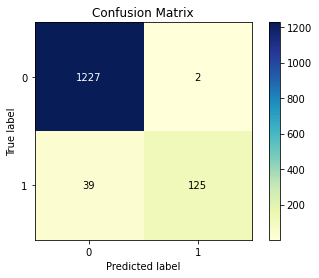

In [26]:
import matplotlib.pyplot as plt
plot_confusion_matrix(y_test, y_test_pred, cmap= 'YlGnBu')
plt.show()

### Random Forest

In [27]:
# Random Forest
rf = RandomForestClassifier(n_estimators= 300)
rf.fit(X_train, y_train)
y_train_prob = rf.predict_proba(X_train)
y_train_pred = rf.predict(X_train)
y_test_prob = rf.predict_proba(X_test)
y_test_pred = rf.predict(X_test)

print('Train: - Acc: {:.4f}'.format(accuracy_score(y_train, y_train_pred)) )
print('Train: - Pre: {:.4f}'.format(precision_score(y_train, y_train_pred)) )
print('Train: - Rec: {:.4f}'.format(recall_score(y_train, y_train_pred)) )
print('Train: - AUC: {:.4f}'.format(roc_auc_score(y_train, y_train_prob[:, 1])) )
print('')
print('Test : - Acc: {:.4f}'.format(accuracy_score(y_test, y_test_pred)) )
print('Test : - Pre: {:.4f}'.format(precision_score(y_test, y_test_pred)) )
print('Test : - Rec: {:.4f}'.format(recall_score(y_test, y_test_pred)) )
print('Test : - AUC: {:.4f}'.format(roc_auc_score(y_test, y_test_prob[:, 1])))

Train: - Acc: 0.9998
Train: - Pre: 1.0000
Train: - Rec: 0.9983
Train: - AUC: 0.9997

Test : - Acc: 0.9821
Test : - Pre: 1.0000
Test : - Rec: 0.8476
Test : - AUC: 0.9852


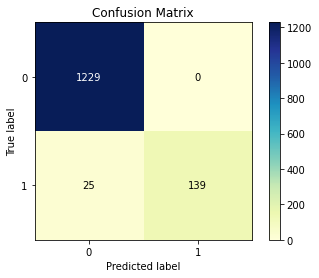

In [28]:
plot_confusion_matrix(y_test, y_test_pred, cmap= 'YlGnBu')
plt.show()

## Method 3: Topic Modeling


In [29]:
#checking for nulls
print("Number of rows with any of the empty columns:", spamdf.isnull().sum().sum())
reviews_df=spamdf.dropna()
restaurant_name = "Category" #id column name
restaurant_review = "Message" #text column name
ntopics= 5 #number of latent topics

Number of rows with any of the empty columns: 0


In [30]:
from nltk.stem import WordNetLemmatizer

word_tokenizer=RegexpTokenizer(r'\w+')
wordnet_lemmatizer = WordNetLemmatizer()
stopwords_nltk=set(stopwords.words('english'))
def tokenize_text(version_desc):
    lowercase=version_desc.lower()
    text = wordnet_lemmatizer.lemmatize(lowercase)
    tokens = word_tokenizer.tokenize(text)
    return tokens
vec_words = CountVectorizer(tokenizer=tokenize_text,stop_words=stopwords_nltk,decode_error='ignore')
total_features_words = vec_words.fit_transform(reviews_df[restaurant_review])
print(total_features_words.shape)
model = lda.LDA(n_topics=int(ntopics), n_iter=500, random_state=1)
model.fit(total_features_words)
topic_word = model.topic_word_
doc_topic=model.doc_topic_
doc_topic=pd.DataFrame(doc_topic)
reviews_df=reviews_df.join(doc_topic)
restaurant=pd.DataFrame()
for i in range(int(ntopics)):
    topic="topic_"+str(i)
    restaurant[topic]=reviews_df.groupby([restaurant_name])[i].mean()
restaurant=restaurant.reset_index()
topics=pd.DataFrame(topic_word)
topics.columns=vec_words.get_feature_names()
topics1=topics.transpose()
print ("Topics word distribution written in file topic_word_dist.xlsx ")
topics1.to_excel("topic_word_dist.xlsx")
restaurant.to_excel("document_topic_dist.xlsx",index=False)
print ("Document topic distribution written in file document_topic_dist.xlsx ")
display(topics1.head())
restaurant.head()

(5572, 8605)
Topics word distribution written in file topic_word_dist.xlsx 
Document topic distribution written in file document_topic_dist.xlsx 


,0,1,2,3,4
0,0.000001,7.927040e-07,0.000419,0.000001,6.415582e-07
00,0.000001,7.927040e-07,0.000001,0.001441,6.415582e-07
000,0.000001,7.927040e-07,0.000314,0.003744,6.415582e-07
000pes,0.000001,8.006310e-05,0.000001,0.000001,6.415582e-07
008704050406,0.000001,7.927040e-07,0.000210,0.000001,6.415582e-07


,Category,topic_0,topic_1,topic_2,topic_3,topic_4
0,ham,0.173038,0.295898,0.065124,0.079551,0.386388
1,spam,0.053407,0.031783,0.516638,0.354115,0.044057


### Observation:
Topics 2 and 3 hold most of the spam. They seem to want the receiver to do something, such as call, text, or go to a link for topic 2, while topic 3 also wants something done but offers prizes or money. Recall: 0.87 by labelling topics 2 and 3 as spam


# Most Common Words for Spam/Ham

In [31]:
import numpy as np
import pandas as pd
spamdf = pd.read_csv("SPAM text message 20170820 - Data.csv")
spamdf.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [32]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+') #removes punctuation, keeps only words

def counts(x): #count frequencies
  return Counter(tokenizer.tokenize((x.lower())))
spams = spamdf[spamdf['Category'] == "spam"]
hams = spamdf[spamdf['Category'] == "ham"]
cspam = spams['Message'].astype(str).apply(counts).sum()
cham = hams['Message'].astype(str).apply(counts).sum()

nltk.download('stopwords')
from nltk.corpus import stopwords #removing stopwords from attributes
allspam = [w for w in cspam if not w.lower() in set(stopwords.words('english'))]
allham = [w for w in cspam if not w.lower() in set(stopwords.words('english'))]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
print("Top spam words")
print(sorted(allspam, key = lambda word:cspam[word], reverse=True)[:25])
print("Top ham words")
print(sorted(allham, key = lambda word:cham[word], reverse=True)[:25])

Top spam words
['call', 'free', '2', 'u', 'txt', 'ur', '4', 'mobile', 'text', 'stop', '1', 'claim', 'reply', 'www', 'prize', 'get', 'cash', 'uk', 'send', '150p', 'new', 'nokia', 'win', 'urgent', 'tone']
Top ham words
['u', '2', 'get', 'ok', 'go', 'ur', 'call', 'know', 'good', 'like', 'got', 'come', 'day', 'love', 'time', '4', 'going', 'one', 'want', 'home', 'need', 'sorry', 'still', 'k', 'n']


# Basic Cosine and Spacy Similarity

In [35]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+') #removes punctuation, keeps only words
def counts(x): #count frequencies
  return Counter(tokenizer.tokenize((x.lower())))
spams = spamdf[spamdf['Category'] == "spam"]
hams = spamdf[spamdf['Category'] == "ham"]
cspam = spams['Message'].astype(str).apply(counts).sum()
cham = hams['Message'].astype(str).apply(counts).sum()
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords #removing stopwords from attributes
allspam = [w for w in cspam if not w.lower() in set(stopwords.words('english'))]
allham = [w for w in cspam if not w.lower() in set(stopwords.words('english'))]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import spacy
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

! pip install spacy
! python -m spacy download en_core_web_md
from sklearn.metrics.pairwise import cosine_similarity
import spacy
nlp = spacy.load("en_core_web_md")

In [42]:
output = pd.DataFrame([spamdf['Category'], spamdf['Message']],index=['Text_Category','Text_Body']).T


In [43]:
top_spam_string = " ".join(top_spam_words)
top_ham_string = " ".join(top_ham_words)
doc1 = nlp(top_spam_string)
doc2 = nlp(top_ham_string)

def spam_spacy_similarity(x):
  return doc1.similarity(nlp(x))

def ham_spacy_similarity(x):
  return doc2.similarity(nlp(x))

spam_spacy_score = spamdf['Message'].astype(str).apply(spam_spacy_similarity)
ham_spacy_score = spamdf['Message'].astype(str).apply(ham_spacy_similarity)

In [46]:
output["Spam_Spacy_Score"] = spam_spacy_score
output["Ham_Spacy_Score"] = ham_spacy_score
output.sort_values(by="Spam_Spacy_Score",ascending=False) # highest spam spacy score is 0.75658

,Text_Category,Text_Body,Spam_Spacy_Score,Ham_Spacy_Score
5342,spam,u r subscribed 2 TEXTCOMP 250 wkly comp. 1st w...,0.756585,0.368501
2527,ham,Do u noe how 2 send files between 2 computers?,0.727893,0.596928
3763,spam,FREE for 1st week! No1 Nokia tone 4 ur mob eve...,0.711697,0.540756
1017,spam,FREE for 1st week! No1 Nokia tone 4 ur mob eve...,0.711697,0.540756
4198,spam,FREE for 1st week! No1 Nokia tone 4 ur mob eve...,0.711697,0.540756
...,...,...,...,...
1764,ham,Joy's father is John. Then John is the NAME of...,-0.152321,0.037698
2688,ham,Okie,-0.163517,-0.161183
5188,ham,Okie,-0.163517,-0.161183
3901,ham,Okie,-0.163517,-0.161183


In [48]:
def spam_BOW_similarity(x):
  documents =[top_spam_string, x]
  count_vectorizer = CountVectorizer(stop_words='english')
  sparse_matrix = count_vectorizer.fit_transform(documents)
  doc_term_matrix = sparse_matrix.todense()
  df = pd.DataFrame(doc_term_matrix,
                    columns=count_vectorizer.get_feature_names(),
                    index=['x', 'y'])
  return cosine_similarity(df, df)[0,1]

def ham_BOW_similarity(x):
  documents =[top_ham_string, x]
  count_vectorizer = CountVectorizer(stop_words='english')
  sparse_matrix = count_vectorizer.fit_transform(documents)
  doc_term_matrix = sparse_matrix.todense()
  df = pd.DataFrame(doc_term_matrix,
                    columns=count_vectorizer.get_feature_names(),
                    index=['x', 'y'])
  return cosine_similarity(df, df)[0,1]

spam_BOW_score = spamdf['Message'].astype(str).apply(spam_BOW_similarity)
ham_BOW_score = spamdf['Message'].astype(str).apply(ham_BOW_similarity)

In [49]:
output["Spam_BOW_Score"] = spam_BOW_score
output["Ham_BOW_Score"] = ham_BOW_score
output

,Text_Category,Text_Body,Spam_Spacy_Score,Ham_Spacy_Score,Spam_BOW_Score,Ham_BOW_Score
0,ham,"Go until jurong point, crazy.. Available only ...",0.402072,0.561139,0.000000,0.076923
1,ham,Ok lar... Joking wif u oni...,0.349120,0.530355,0.000000,0.124035
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,0.338481,0.225715,0.157243,0.000000
3,ham,U dun say so early hor... U c already then say...,0.376518,0.558364,0.000000,0.000000
4,ham,"Nah I don't think he goes to usf, he lives aro...",0.059068,0.532272,0.000000,0.000000
...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,0.503688,0.470437,0.129641,0.067267
5568,ham,Will ü b going to esplanade fr home?,0.371662,0.551186,0.000000,0.277350
5569,ham,"Pity, * was in mood for that. So...any other s...",0.211630,0.501674,0.000000,0.000000
5570,ham,The guy did some bitching but I acted like i'd...,0.233782,0.626335,0.084515,0.087706


In [52]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
    return sentiment_dict['compound']

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 5.3 MB/s 


In [53]:
sentiment_scores_list = []
for review in output["Text_Body"]:
  sentiment_score = sentiment_scores(review)
  sentiment_scores_list.append(sentiment_score)

In [54]:
sorted(sentiment_scores_list)[:5]

[-0.9524, -0.9524, -0.9042, -0.9042, -0.9042]

In [55]:
positive = filter(lambda score: score > 0, sentiment_scores_list)
len(list(positive))/len(sentiment_scores_list) 

0.4876166547020818

In [57]:
output.sort_values(by="Sentiment_Score",ascending=False) # highest sentiment score is 0.9966

,Text_Category,Text_Body,Spam_Spacy_Score,Ham_Spacy_Score,Spam_BOW_Score,Ham_BOW_Score,Sentiment_Score
3017,ham,"&lt;#&gt; is fast approaching. So, Wish u a v...",0.113462,0.157296,0.000000,0.111903,0.9966
1579,ham,How to Make a girl Happy? It's not at all diff...,0.178500,0.057590,0.000000,0.021117,0.9906
2356,ham,"Hello, my love ! How went your day ? Are you a...",0.235767,0.664089,0.049629,0.154508,0.9817
5318,ham,"Good morning, my Love ... I go to sleep now an...",0.246994,0.689091,0.000000,0.277350,0.9815
1085,ham,For me the love should start with attraction.i...,0.244639,0.632403,0.000000,0.283069,0.9808
...,...,...,...,...,...,...,...
3280,ham,Solve d Case : A Man Was Found Murdered On &l...,0.295800,0.393840,0.033942,0.000000,-0.9042
2681,ham,Solve d Case : A Man Was Found Murdered On &l...,0.295800,0.393840,0.033942,0.000000,-0.9042
2408,ham,Solve d Case : A Man Was Found Murdered On &l...,0.295800,0.393840,0.033942,0.000000,-0.9042
298,ham,Hurt me... Tease me... Make me cry... But in t...,0.258881,0.630116,0.000000,0.071611,-0.9524


# Basic Cosine and Spacy Accuracy 

In [59]:
mask1 = output["Text_Category"] == "spam" # 747 rows are actual spam
mask2 = output["Text_Category"] == "ham" # 4825 rows are actual ham


In [65]:
mask3 = output['Spam_BOW_Score'] > output['Ham_BOW_Score'] # predicted to be Spam
mask4 = output['Ham_BOW_Score'] > output['Spam_BOW_Score'] # predicted to be ham
mask5 = output['Spam_Spacy_Score'] > output['Ham_Spacy_Score'] # predicted to be spam
mask6 = output['Ham_Spacy_Score'] > output['Spam_Spacy_Score'] # predicted to be ham


In [66]:
# Accuracy = (TP + TN) / (TP + TN + FP + FN)
(554 + 1944) / (4825 + 747) # Basic cosine similarity gives an accuracy of 44.83%

0.4483129935391242

,Text_Category,Text_Body,Spam_Spacy_Score,Ham_Spacy_Score,Spam_BOW_Score,Ham_BOW_Score,Sentiment_Score
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,0.338481,0.225715,0.157243,0.000000,0.7964
9,spam,Had your mobile 11 months or more? U R entitle...,0.441339,0.340838,0.239046,0.000000,0.8747
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",0.578386,0.420675,0.291606,0.060523,0.7088
12,spam,URGENT! You have won a 1 week FREE membership ...,0.455432,0.300355,0.306570,0.000000,0.9343
15,spam,"XXXMobileMovieClub: To use your credit, click ...",0.501099,0.362610,0.059761,0.000000,0.3818
...,...,...,...,...,...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,0.385202,0.254594,0.000000,0.071611,0.1511
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,0.388282,0.167735,0.055728,0.115663,0.9180
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,0.400872,0.392338,0.239046,0.000000,0.7620
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,0.559475,0.524345,0.207020,0.000000,0.8442


In [ ]:
(406+4538)/(747+4825) # spacy gives 88.73% accuracy

In [67]:
np.average(output[mask1]["Sentiment_Score"]) # actual spam has average sentiment score = 0.436

0.4360421686746988

In [68]:
np.average(output[mask2]["Sentiment_Score"]) # actual ham has average sentiment score = 0.164

0.1635356476683938

In [69]:
np.average(output[mask3]["Sentiment_Score"]) # BOW predicted spam has average sentiment score = 0.410

0.4101321614583333

In [70]:
np.average(output[mask4]["Sentiment_Score"]) # BOW predicted Ham has average sentiment score = 0.256

0.256385501489573

In [71]:
np.average(output[mask5]["Sentiment_Score"]) # Spacy predicted spam has average sentiment score = 0.352

0.3518813953488372

In [72]:
np.average(output[mask6]["Sentiment_Score"]) # Spacy predicted ham has average sentiment score = 0.179

0.1789029520295203

### Insights:
* Spam messages are longer on average, with about 14 words per ham message and 24 words per spam
* Supervised Classifier Models are able to discriminate spam messages from ham messages, since the baseline metrics are good enough.
* Spacy gives a accuracy that’s almost twice as Basic Cosine similarity, since it picks up the context and recognizes typos and synonyms while basic cosine similarity only looks at exact matches of words.
* Based on topic modeling, messages that want the receiver to do something or offers prizes and cash are much more likely to be spam.
